In [1]:
# Package imports
import random
from random import randint
import time

import os
import json
import string
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import contextily as cx
import warnings
import shapely
from shapely.geometry import Point, Polygon, LineString, LinearRing
from shapely import oriented_envelope, affinity
import math
from tqdm import tqdm
 
# prints parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 21 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


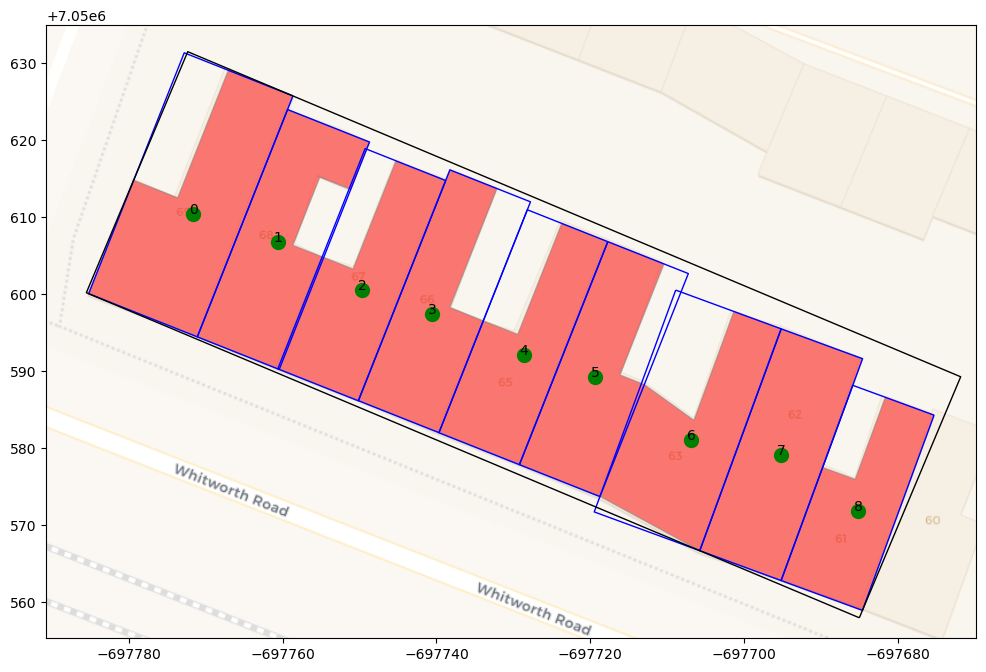

In [2]:
gdf = gpd.read_file(f'{parent_dir}/geojson_polygons/whitworth_buildings.geojson')
convert = True
if convert and gdf.crs == 'EPSG:4326':
    gdf = gdf.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(12,8))
gdf['coords'] = gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
gdf['coords'] = [coords[0] for coords in gdf['coords']]
gdf['name'] = [idx for idx in range(len(gdf))]

gdf_subset = gdf.iloc[933:942]
gdf_subset['mbr'] = gdf_subset['geometry'].apply(lambda x: oriented_envelope(x))

poly_933 = gdf_subset.iloc[0]['geometry']
gdf_subset['name'] = [idx for idx in range(len(gdf_subset))]

gdf_subset.plot(ax=ax, edgecolor='grey', facecolor='red', alpha=0.5)
gdf_subset['mbr'].plot(ax=ax, edgecolor='blue', facecolor='none')
gdf_subset['geometry'].centroid.plot(ax=ax, color='green', markersize=100)


cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)

gdf_subset.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

oriented_envelope(gdf_subset.dissolve()['geometry']).plot(ax=ax, edgecolor='black', facecolor='none')

plt.show()

In [56]:
df = pd.DataFrame(gdf_subset['geometry'].centroid.reset_index(drop=True), columns=['geometry'])

print(df)

df['x'] = df['geometry'].apply(lambda p: p.x)
df['y'] = df['geometry'].apply(lambda p: p.y)

print(df.sort_index(ascending=False))



                          geometry
0  POINT (-697771.574 7050610.465)
1  POINT (-697760.551 7050606.853)
2  POINT (-697749.630 7050600.575)
3  POINT (-697740.586 7050597.452)
4  POINT (-697728.682 7050592.148)
5  POINT (-697719.410 7050589.263)
6  POINT (-697706.891 7050581.099)
7  POINT (-697695.222 7050579.172)
8  POINT (-697685.197 7050571.841)
                          geometry              x             y
8  POINT (-697685.197 7050571.841) -697685.197331  7.050572e+06
7  POINT (-697695.222 7050579.172) -697695.222196  7.050579e+06
6  POINT (-697706.891 7050581.099) -697706.891099  7.050581e+06
5  POINT (-697719.410 7050589.263) -697719.409605  7.050589e+06
4  POINT (-697728.682 7050592.148) -697728.681666  7.050592e+06
3  POINT (-697740.586 7050597.452) -697740.585603  7.050597e+06
2  POINT (-697749.630 7050600.575) -697749.630006  7.050601e+06
1  POINT (-697760.551 7050606.853) -697760.551088  7.050607e+06
0  POINT (-697771.574 7050610.465) -697771.574405  7.050610e+06


/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

AttributeError: 'Series' object has no attribute 'geometry'

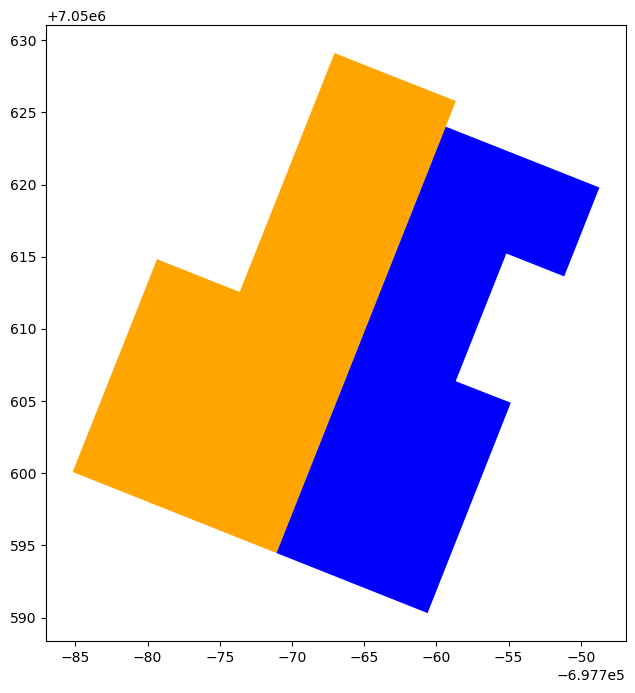

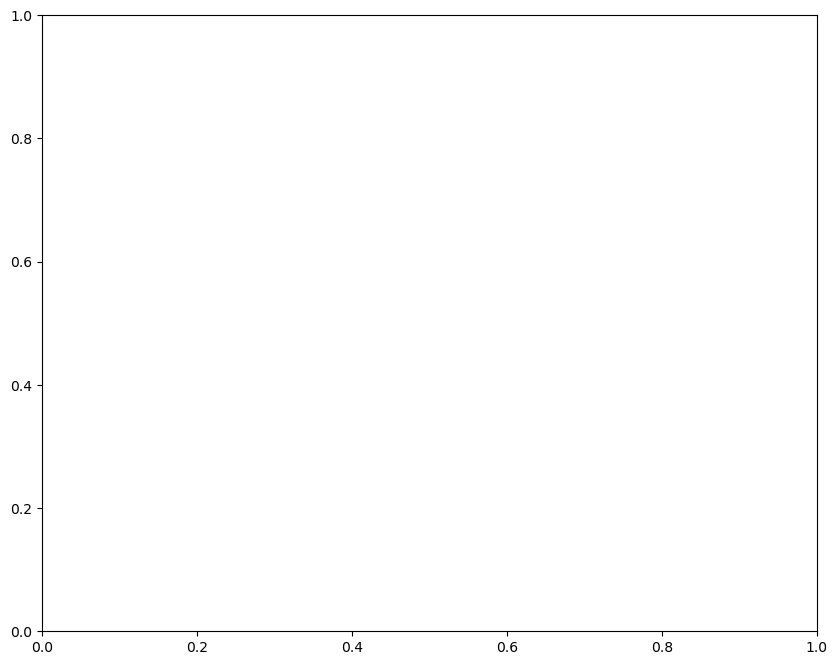

In [89]:
def move_gdf(gdf_poly, gdf_p):
    gdf_poly['new_centroid'] = gdf_p['geometry'].centroid
    gdf_poly['delta_x'] = gdf_poly['new_centroid'].x - gdf_poly['geometry'].centroid.x
    gdf_poly['delta_y'] = gdf_poly['new_centroid'].y - gdf_poly['geometry'].centroid.y

    #gdf_poly['geometry'] = gdf_poly['geometry'].apply(lambda geom: affinity.translate(geom, xoff=gdf_poly['offset'], yoff=0))
    gdf_poly['geometry'] = gdf_poly.apply(lambda gdf: affinity.translate(gdf.geometry, xoff=gdf.delta_x, yoff=gdf.delta_y))
    return gdf_poly

def move_poly(df, c_new):
    x_old, y_old = df['geometry'].centroid.x, df['geometry'].centroid.y
    x_new, y_new = c_new.x, c_new.y

    delta_x = x_new - x_old
    delta_y = y_new - y_old

    print("delta_x", float(delta_x), "delta_y", delta_y)


    df['geometry'] = df['geometry'].apply(lambda geom: affinity.translate(geom, xoff=delta_x, yoff=delta_y))

    return df

def poly_swap(df_a, df_b):
    df_temp = df_a
    df_a = move_poly(df_a, df_b['geometry'].iloc[0].centroid)
    df_b = move_poly(df_b, df_temp['geometry'].iloc[0].centroid)
    return df_a, df_b

fig, ax = plt.subplots(1,1,figsize=(10,8))

poly_a = gdf_subset.iloc[[0]]
poly_b = gdf_subset.iloc[[1]]

poly_a.plot(ax=ax, facecolor='orange')
poly_b.plot(ax=ax, facecolor='blue')

fig, ax = plt.subplots(1,1,figsize=(10,8))

poly_a = move_gdf(poly_a, poly_b[['geometry']])

poly_a.plot(ax=ax, facecolor='orange')
poly_b.plot(ax=ax, facecolor='blue')


